# Toy Problem #1


Approach: Read the data in from the csv files.

- Create a GeoDataFrame object out of this
- Create a dual graph so that each node represents a street and the geometries between them
- Use VRP process on nodes

New Heuristics Approach: based on https://researchrepository.wvu.edu/cgi/viewcontent.cgi?article=5362&context=etd



# Step 1 - Read Data and Create Graph

In [3]:
import networkx as nx
import math
import pandas as pd
import osmnx as ox
import geopandas as gpd
import momepy
import matplotlib.pyplot as plt
import itertools
import numpy as np

Read the edges and nodes

In [4]:
edgelist = pd.read_csv("edges.csv")
nodelist = pd.read_csv("nodes.csv")

Create graph

In [5]:
G = nx.Graph()
for i,edges in edgelist.iterrows():
    G.add_edge(edges.iloc[0],edges.iloc[1],**edges.iloc[2:].to_dict())

for i,nodes in nodelist.iterrows():
    nx.set_node_attributes(G, {nodes['id']:  nodes[1:].to_dict()})  


Take a step back and visualize the data in our graph

In [6]:
print('# of edges: {}'.format(G.number_of_edges()))
print('# of nodes: {}'.format(G.number_of_nodes()))

print(G.edges(data=True))
print(G.nodes(data=True))

# of edges: 6
# of nodes: 5
[('depot', 'home', {'distance': 1, 'priority': 1, 'time': 1, 'passes': 1}), ('depot', 'school', {'distance': 2, 'priority': 1, 'time': 2, 'passes': 1}), ('depot', 'grocery', {'distance': 7, 'priority': 2, 'time': 7, 'passes': 1}), ('school', 'grocery', {'distance': 5, 'priority': 2, 'time': 5, 'passes': 1}), ('school', 'hospital', {'distance': 3, 'priority': 3, 'time': 3, 'passes': 2}), ('grocery', 'hospital', {'distance': 3, 'priority': 3, 'time': 3, 'passes': 2})]
[('depot', {'x': 0, 'y': 0}), ('home', {'x': 1, 'y': 0}), ('school', {'x': 0, 'y': 2}), ('grocery', {'x': 5, 'y': 2}), ('hospital', {'x': 3, 'y': 7})]


##### Visualize the Graph

In [7]:
# Define node positions data structure (dict) for plotting
node_positions = {node[0]: (node[1]['x'], node[1]['y']) for node in G.nodes(data=True)}

# Preview of node_positions with a bit of hack (there is no head/slice method for dictionaries).
dict(list(node_positions.items())[0:5])


{'depot': (0, 0),
 'home': (1, 0),
 'school': (0, 2),
 'grocery': (5, 2),
 'hospital': (3, 7)}

Now plot

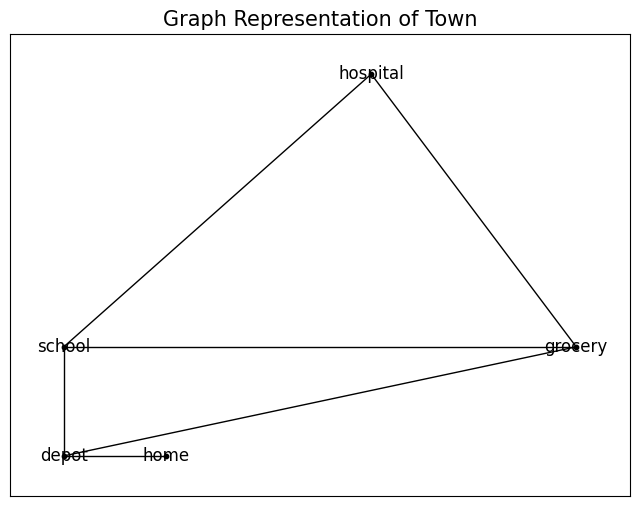

In [8]:
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos=node_positions, node_size=10, node_color='black', with_labels=True)
plt.title('Graph Representation of Town', size=15)
plt.show()

Visualize Paramters

In [9]:
for edge in G.edges(data=True):
    print(edge)

('depot', 'home', {'distance': 1, 'priority': 1, 'time': 1, 'passes': 1})
('depot', 'school', {'distance': 2, 'priority': 1, 'time': 2, 'passes': 1})
('depot', 'grocery', {'distance': 7, 'priority': 2, 'time': 7, 'passes': 1})
('school', 'grocery', {'distance': 5, 'priority': 2, 'time': 5, 'passes': 1})
('school', 'hospital', {'distance': 3, 'priority': 3, 'time': 3, 'passes': 2})
('grocery', 'hospital', {'distance': 3, 'priority': 3, 'time': 3, 'passes': 2})


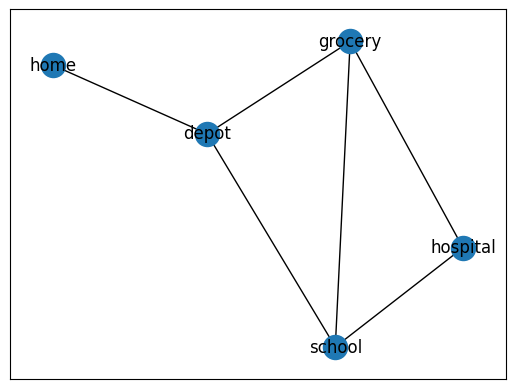

In [10]:
# Set the seed for the spring layout
spring_pos = nx.spring_layout(G, seed=1)

# Draw the graph using the spring layout
nx.draw_networkx(G, pos=spring_pos, with_labels=True)
plt.show()

# Step 2: Route Construction Algorithm (RCA)

Variables:
| Variable | Definition 
|:--------:|:--------:|
|  RCL |  Restricted Candidate List |
|  $\alpha$   |  Threshold parameter. Value between 0 and 1  
|  C<sub>min   | Lowest incremental cost of a candidate element to be added to the partial solution    |
| C<sub>max | Highest incremental cost of a candidate element to be added to the partial solution|
|E| List of possible candidates that can be added to the partial solution
|No_Routes|Number of routes developed in the network



Overview:
1. If there is at least one required arc from the current node, then create a restricted candidate list based on the neighbors of the current node. Otherwise go to step 3
2. If RCL is empty, go to step 3. Otherwise choose a random arc from the RCL based on the threshold parameter and cost range
3. Go through the list of all required arcs and find the closest one.

Initialize model parameters

In [25]:
number_of_routes = 0 # set initial number of routes to zero
curr_node = 'depot' # set starting node to depot
alpha = 0.4 # set alpha parameter
c_min = 0 # set minimum cost to zero
c_max = 10 # set maximum cost to 10

edge_requirements = nx.get_edge_attributes(G, 'passes') # get edge requirements

{('depot', 'home'): 1, ('depot', 'school'): 1, ('depot', 'grocery'): 1, ('school', 'grocery'): 1, ('school', 'hospital'): 2, ('grocery', 'hospital'): 2}


Calculate shortest distance between each pair of nodes in the network using
Floyd's algorithm and visualize distance matrix

In [12]:
nx.floyd_warshall_numpy(G,weight="distance")

array([[0., 1., 2., 7., 5.],
       [1., 0., 3., 8., 6.],
       [2., 3., 0., 5., 3.],
       [7., 8., 5., 0., 3.],
       [5., 6., 3., 3., 0.]])

In [13]:
for i, node in enumerate(G.nodes):
    print(i, node)

0 depot
1 home
2 school
3 grocery
4 hospital


Define a cost function for traversing an arc

In [14]:
def cost(node1, node2):
    '''
    Returns the cost of traversing an edge between two nodes. Doesn't include priorities yet. 
    Currently based solely on distance.
    '''
    edge_data = G.get_edge_data(node1, node2)

    cost = edge_data['distance']
    return cost

### Start finding a route

In [15]:
partial_route = [] # initialize route list
partial_cost = 0

Add an arc to the RCL if it has a cost in the range 
$$R = [C_{min}, C_{min} + \alpha \cdot (C_{max}-C_{min})]$$

Determine C<sub>min</sub> and C<sub>max</sub> by looping through first

In [22]:
rcl = [] # initialize restricted candidate list

c_min = math.inf
c_max = -math.inf
for neighbor in G.neighbors(curr_node):
    c_min = min(cost(curr_node, neighbor), c_min)
    c_max = max(cost(curr_node, neighbor), c_max)
for neighbor in G.neighbors(curr_node):
    if cost(curr_node, neighbor) >= c_min and cost(curr_node, neighbor) <= c_min + alpha*(c_max-c_min):
        rcl.append(neighbor)
print(rcl)

1 7
['home', 'school']


Randomly choose an arc if the RCL isn't empty

In [23]:
if (len(rcl) > 0):
    next_node = np.random.choice(rcl)
    partial_route.append(next_node) # update partial route
    partial_cost += cost(curr_node, next_node) # update cost

    # check if (curr_node, next_node) is a key in edge_requirements
    if (curr_node, next_node) in edge_requirements:
        edge_requirements[(curr_node, next_node)] -= 1 # update edge requirements
    else:
        edge_requirements[(next_node, curr_node)] -= 1 # update edge requirements
    curr_node = next_node # advance route

else:
    
    
